# ECE 689, Spring 2025
## Homework 3

## Full name: Jin Yi Yong

## Question 1: Transformer for translation

Here, we implement transformers for neural machine translation (NMT), such as turning "Hello world" to "Salut le monde". You are going to follow the following steps:
1. Load and prepare the data. We provide "en-ft.txt". Each line of this file contains an English phrase, the equivalent French phrase, and an attribution identifying where the translation came from. The en-fr.txt used in problem 3 can also be found at: https://github.com/jeffprosise/Applied-Machine-Learning/tree/main/Chapter%2013/Data
2. Build and train a model. Implement a transformer from scratch in Pytorch. We will provide you with an existing implementation in Keras. You might also find https://github.com/gordicaleksa/pytorch-original-transformer useful.

For deliverables, plot your training and validation accuracy. The x-axis should be epoch, the y-axis should be your translation accuracy.

For reference, the provided code given at https://github.com/jeffprosise/Applied-Machine-Learning/blob/main/Chapter%2013/Neural%20Machine%20Translation%20(Transformer).ipynb achieves 85% accuracy after 14 epochs. You do not have to achieve the same performance to get full marks, just show understanding and functional codes.

In [1]:
"""Clean the text by removing punctuation symbols and numbers, converting
characters to lowercase, and replacing Unicode characters with their ASCII
equivalents. For the French samples, insert [start] and [end] tokens at the
 beginning and end of each phrase"""
import re
from unicodedata import normalize

import pandas as pd

df = pd.read_csv('Data/en-fr.txt', names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

def clean_text(text):
    """ Normalize the text to its canonical form, "NFD" means "Normalization Form D", 
    which decomposes characters into their base characters and combining diacritical marks
    """
    text = normalize('NFD', text.lower())
    # Remove all non-alphabetic characters
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,en,fr
0,youre very clever,[start] vous etes fort ingenieuse [end]
1,are there kids,[start] y atil des enfants [end]
2,come in,[start] entrez [end]
3,wheres boston,[start] ou est boston [end]
4,you see what i mean,[start] vous voyez ce que je veux dire [end]


In [2]:
"""The next step is to scan the phrases and determine the maximum length of the
English phrases and then of the French phrases. These lengths will determine
the lengths of the sequences input to and output from the model"""
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)
sequence_len = max(en_max_len, fr_max_len)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (English): 7
Max phrase length (French): 16
Sequence length: 16


In [3]:
"""Now fit one Tokenizer to the English phrases and another Tokenizer to their
French equivalents, and generate padded sequences for all the phrases"""
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=sequence_len, padding='post')

fr_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n')
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=sequence_len + 1, padding='post')

2025-03-06 13:03:13.003273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741284193.022576 3578589 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741284193.028650 3578589 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 13:03:13.051576: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
"""Compute the vocabulary sizes from the Tokenizer instances"""
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6033
Vocabulary size (French): 12197


In [6]:
"""Finally, create the features and the labels the model will be trained with.
The features are the padded English sequences and the padded French sequences
minus the [end] tokens. The labels are the padded French sequences minus the
[start] tokens. Package the features in a dictionary so they can be input to a
model that accepts multiple inputs."""
inputs = { 'encoder_input': en_x, 'decoder_input': fr_y[:, :-1] }
outputs = fr_y[:, 1:]

Now, define and train the transformer in Pytorch. We provide here some example code in Keras, **but note that you have to write it in Pytorch**.

In [7]:
# PyTorch Implementation of Transformer for NMT
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformer import Transformer

%matplotlib inline
sns.set()

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Token indices
PAD_IDX = 0
START_IDX = 1  # Corresponds to [start] token
END_IDX = 2    # Corresponds to [end] token

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class LabelSmoothing(nn.Module):
    """
    A module that implements label smoothing for classification tasks using Kullback-Leibler Divergence loss.

    Label smoothing is a regularization technique that replaces the hard target (one-hot) labels
    with a softer distribution. Instead of assigning a probability of 1.0 to the ground-truth class and 0.0 to others,
    label smoothing assigns a probability of (1 - smoothing) to the true class and distributes the smoothing value
    equally among the remaining classes. This approach can help the model to generalize better by preventing it
    from becoming overconfident in its predictions.

    Steps:
    1. Input Verification:
       - The `forward` method asserts that the last dimension of the input tensor `x` corresponds to the number
         of classes (`size`). This ensures consistency in the prediction tensor's shape.

    2. Initialization of Target Distribution:
       - A copy of the input tensor `x` is created to serve as a template for the target (smoothed) distribution.
       - The entire target distribution tensor is then filled with a uniform smoothing value calculated as:
         smoothing value = smoothing / (size - 2)
         This formula assumes that one slot is reserved for the correct class and another for the padding token.

    3. Assigning the Correct Class Probability:
       - For each position in the target tensor, the correct class (as specified by `target`) is assigned a high
         confidence value of (1.0 - smoothing) by scattering the value into the correct position.

    4. Handling of Padding Token:
       - The probability assigned to the padding index is explicitly set to 0 so that it does not influence the loss.
       - Additionally, any position in the target containing a padding token is masked out by zeroing out its entire distribution.

    5. Loss Computation:
       - The smoothed target distribution is compared against the model's predicted distribution using KL-divergence.
       - Since the criterion expects log-probabilities from the model predictions, log(x) is provided as input
         to the KLDivLoss function.

    Args:
        size (int): Number of classes (i.e., the vocabulary size).
        padding_idx (int): Index used for the padding token. No probability mass is assigned to this index.
        smoothing (float, optional): Smoothing factor to use. Default is 0.1. The true label is assigned
                                     a probability of \((1.0 - \text{smoothing})\) and the remaining probability mass is
                                     uniformly distributed over the other classes.

    Attributes:
        criterion (nn.KLDivLoss): The loss function instance used to compute the divergence between the predicted
                                  distribution (after log-softmax) and the smoothed target distribution.
        confidence (float): The probability reserved for the correct class, computed as \((1.0 - \text{smoothing})\).
        smoothing (float): The smoothing parameter provided.
        size (int): The number of classes.
        true_dist (Tensor): A tensor storing the computed smoothed target distribution (updated each forward pass).
    """

    def __init__(self, size, padding_idx, smoothing=0.1):
        super().__init__()
        # Initialize the KLDivLoss with reduction sum to accumulate the loss over all items.
        self.criterion = nn.KLDivLoss(reduction='batchmean')

        # The index for the padding token.
        self.padding_idx = padding_idx

        # Confidence is the probability mass to assign to the true label.
        self.confidence = 1.0 - smoothing

        # The smoothing factor used.
        self.smoothing = smoothing

        # The total number of classes.
        self.size = size

        # A placeholder for the target distribution (useful for debugging or analysis).
        self.true_dist = None

    def forward(self, x, target):
        """
        Compute the label smoothing loss given the model predictions and the target labels.

        Steps:
        1. Verify that the last dimension of x matches 'size'.
        2. Create a copy of x to initialize the true distribution.
        3. Fill the distribution with a uniform value \(\frac{\text{smoothing}}{\text{size} - 2}\).
        4. Scatter the high confidence value into the position of the actual target token.
        5. Set the probability for the padding index to 0.
        6. Mask out any positions where the target is the padding token.
        7. Compute and return the KL-divergence loss between the log of predictions and the smoothed targets.

        Args:
            x (Tensor): Model output predictions with shape (batch_size, sequence_length, size).
                        These are raw scores (not log-probabilities).
            target (Tensor): Ground truth token indices with shape (batch_size, sequence_length).

        Returns:
            Tensor: The computed KL-divergence loss.
        """
        # Ensure the prediction tensor is of the expected shape.
        assert x.size(-1) == self.size, (
            "The last dimension of x must be equal to the number of classes (size)."
        )

        # Create a copy of x to use as a template for the true (smoothed) distribution.
        true_dist = x.clone()  # shape: (batch_size, sequence_length, size)

        # Fill the entire true_dist with the uniform smoothing value.
        # We subtract 2 from size to account for the correct class and the padding token.
        true_dist.fill_(
            self.smoothing / (self.size - 2)
        )  # shape: (batch_size, sequence_length, size)

        # Scatter the confidence value into the positions corresponding to the ground truth tokens.
        # For each position in the batch, the target token index gets the high probability (confidence).
        true_dist.scatter_(
            -1, target.unsqueeze(-1), self.confidence
        )  # shape: (batch_size, sequence_length, size)

        # Ensure that the padding index is assigned a probability of 0.
        true_dist[:, self.padding_idx] = 0

        # Create a mask for positions where the target is the padding token.
        mask = torch.nonzero(target == self.padding_idx)

        # For these positions, zero out the probability distribution.
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)

        # store the computed smoothed true distribution for debugging or analysis.
        self.true_dist = true_dist

        # Compute and return the KL divergence loss.
        # Note that x is converted to log-probabilities before loss calculation.
        return self.criterion(x, true_dist)

# Prepare datasets from Keras tokenized data
def prepare_dataset_from_keras(en_x, fr_y, batch_size=64):
    """
    Convert Keras tokenized data to PyTorch datasets
    """
    # Convert to PyTorch tensors
    en_x_torch = torch.tensor(en_x, dtype=torch.long)
    fr_y_input_torch = torch.tensor(fr_y[:, :-1], dtype=torch.long)
    fr_y_output_torch = torch.tensor(fr_y[:, 1:], dtype=torch.long)
    
    # Create training dataset
    train_size = int(0.8 * len(en_x_torch))
    train_dataset = TensorDataset(
        en_x_torch[:train_size], 
        fr_y_input_torch[:train_size], 
        fr_y_output_torch[:train_size]
    )
    
    # Create validation dataset
    val_dataset = TensorDataset(
        en_x_torch[train_size:], 
        fr_y_input_torch[train_size:], 
        fr_y_output_torch[train_size:]
    )
    
    # Create data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_dataloader, val_dataloader

def create_masks(src, tgt, pad_idx=PAD_IDX):
    """
    Create masks for transformer training.

    The function generates two masks to be used in the transformer model:
    1. Source Mask (src_mask): Masks padding tokens in the source sequence to prevent the model from
       attending to those positions.
    2. Target Mask (tgt_mask): Combines two types of masks for the target sequence:
        - Padding Mask: Masks padding tokens.
        - No-Look-Ahead Mask: Prevents positions in the target sequence from attending to future tokens
         (enforcing an autoregressive behavior during training).

    Steps:
    1. Determine the batch size from the shape of the source tensor.
    2. Source mask creation:
        - Compare the source tensor with the padding token index to get a binary mask where tokens not equal to
         the padding token are True.
        - Reshape the mask to have shape (batch_size, 1, 1, src_seq_len) so it can be broadcasted across
         the multi-head attention computations.
        - This shape is used because the attention weight matrix has the shape (batch_size, num_heads, query_length, key_length).
         Therefore the (1, 1) dimensions are used to broadcast the mask across the query and key lengths.

    3. Target mask creation:
        a. Determine the target sequence length.
        b. Generate the target padding mask similar to the source mask:
            - This masks out the padding tokens of the target sequence.
            - The target padding mask shape is adjusted to (batch_size, 1, 1, tgt_seq_len).
        c. Create the no-look-ahead mask (autoregressive constraint):
            - Build a mask of shape (1, 1, tgt_seq_len, tgt_seq_len) using torch.triu, which creates an upper-triangular matrix.
            - The mask is used to ensure a position in the target sequence can only attend to positions in the past and
            the present (i.e., lower triangular including the diagonal). Transposing is applied though in this case it
            maintains the same shape.
        d. Combine the target padding mask and the no-look-ahead mask using a logical AND:
            - Both conditions must be satisfied. That is, a token is attendable if it is not a pad token and if it is
            not in the future relative to the current token.
        e. Note that combining the target padding mask and the no-look-ahead mask results in a tensor of shape (batch_size, 1, tgt_seq_len, tgt_seq_len).
    4. Return the source mask and the combined target mask.

    Args:
        src (Tensor): Source token indices with shape [batch_size, src_seq_len].
        tgt (Tensor): Target token indices with shape [batch_size, tgt_seq_len].
        pad_idx (int): The index representing the padding token in the vocabulary.

    Returns:
        tuple: (src_mask, tgt_mask) where:
            - src_mask: Tensor of shape [batch_size, 1, 1, src_seq_len] used to mask source padding tokens.
            - tgt_mask: Tensor of shape [batch_size, 1, tgt_seq_len, tgt_seq_len] used to mask both target padding tokens
              and future tokens (no look-ahead).
    """
    # 1. Determine the batch size from the source tensor shape.
    batch_size = src.shape[0]

    # 2. Create the source mask:
    # Compare each token with pad_idx -> True where token != pad_idx.
    # Reshape to (batch_size, 1, 1, src_seq_len) for compatibility in multi-head attention.
    src_mask = (src != pad_idx).view(batch_size, 1, 1, -1)

    # 3. Create the target mask:
    # a. Determine the target sequence length.
    tgt_seq_len = tgt.shape[1]

    # b. Create the target padding mask:
    # This is similar to the src_mask but for the target. It marks all positions that are not pad tokens.
    # Reshape to (batch_size, 1, 1, tgt_seq_len).
    tgt_padding_mask = (tgt != pad_idx).view(batch_size, 1, 1, -1)

    # c. Create the no-look-ahead mask (autoregressive constraint):
    # This mask is designed to prevent each position from attending to future positions.
    # The mask is created as an upper triangular matrix of ones.
    # Here, we first create a matrix of ones with shape (1, 1, tgt_seq_len, tgt_seq_len) on the same device as tgt,
    # then use torch.triu to keep only the upper triangular region.
    # Transposing ensures the correct shape and orientation (but might be unnecessary in this case)
    device = tgt.device
    tgt_no_look_forward_mask = torch.triu(
        torch.ones((1, 1, tgt_seq_len, tgt_seq_len), device=device) == 1
    ).transpose(2, 3)

    # d. Combine both target masks:
    # The final target mask is the logical AND operation between the padding mask and the no-look-ahead mask.
    # This ensures that only valid positions (non-padding and not attending to future tokens) are allowed.
    tgt_mask = tgt_padding_mask & tgt_no_look_forward_mask

    return src_mask, tgt_mask



<>:31: SyntaxWarning: invalid escape sequence '\('
<>:101: SyntaxWarning: invalid escape sequence '\('
<>:31: SyntaxWarning: invalid escape sequence '\('
<>:101: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_3578589/2157711965.py:31: SyntaxWarning: invalid escape sequence '\('
  """
/tmp/ipykernel_3578589/2157711965.py:101: SyntaxWarning: invalid escape sequence '\('
  """


Using device: cuda


In [8]:
def train_model(train_dataloader, val_dataloader, model, criterion, optimizer, scheduler=None, num_epochs=10, device="cpu"):
    """
    Train the transformer model
    """
    model.train()
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (src, tgt_input, tgt_output) in enumerate(train_dataloader):
            src, tgt_input, tgt_output = src.to(device), tgt_input.to(device), tgt_output.to(device)
            
            # Create masks
            src_mask, tgt_mask = create_masks(src, tgt_input)
            src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)
            
            # Forward pass
            output = model(
                src=src, 
                tgt=tgt_input, 
                src_mask=src_mask,
                tgt_mask=tgt_mask
            )
            
            # Calculate loss
            loss = criterion(output.contiguous().view(-1, output.size(-1)), tgt_output.contiguous().view(-1))
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update scheduler if provided
            if scheduler is not None:
                scheduler.step()
                
            # Compute accuracy
            _, predicted = torch.max(output, dim=2)
            mask = (tgt_output != PAD_IDX)
            train_correct += ((predicted == tgt_output) & mask).sum().item()
            train_total += mask.sum().item()
            
            train_loss += loss.item()
            
            # Print progress
            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}')
        
        # Compute training metrics
        train_loss /= len(train_dataloader)
        train_acc = train_correct / train_total if train_total > 0 else 0
        
        # Evaluate on validation set
        val_loss, val_acc = evaluate_model(val_dataloader, model, criterion, device)
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, 'best_transformer_model.pt')
            
        # Print epoch summary
        time_taken = time.time() - start_time
        print(f'Epoch {epoch+1}/{num_epochs} - {time_taken:.2f}s - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}')
    
    # Load best model
    model.load_state_dict(torch.load('best_transformer_model.pt'))
    
    return history

def evaluate_model(dataloader, model, criterion, device):
    """
    Evaluate model on a dataset
    """
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for src, tgt_input, tgt_output in dataloader:
            src, tgt_input, tgt_output = src.to(device), tgt_input.to(device), tgt_output.to(device)
            
            # Create masks
            src_mask, tgt_mask = create_masks(src, tgt_input)
            src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)
            
            # Forward pass
            output = model(
                src=src, 
                tgt=tgt_input, 
                src_mask=src_mask,
                tgt_mask=tgt_mask
            )
            
            # Calculate loss
            loss = criterion(output.contiguous().view(-1, output.size(-1)), tgt_output.contiguous().view(-1))
            val_loss += loss.item()
            
            # Compute accuracy
            _, predicted = torch.max(output, dim=2)
            mask = (tgt_output != PAD_IDX)
            val_correct += ((predicted == tgt_output) & mask).sum().item()
            val_total += mask.sum().item()
    
    # Compute validation metrics
    val_loss /= len(dataloader)
    val_acc = val_correct / val_total if val_total > 0 else 0
    
    model.train()
    return val_loss, val_acc

def plot_history(history):
    """
    Plot training and validation metrics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

Preparing datasets...
Creating Transformer model...
Model has 19,800,485 trainable parameters
Training model...
Epoch 1/20, Batch 50/625, Loss: 2.5523
Epoch 1/20, Batch 100/625, Loss: 2.2262
Epoch 1/20, Batch 150/625, Loss: 2.2169
Epoch 1/20, Batch 200/625, Loss: 1.8584
Epoch 1/20, Batch 250/625, Loss: 1.8430
Epoch 1/20, Batch 300/625, Loss: 1.6873
Epoch 1/20, Batch 350/625, Loss: 1.4821
Epoch 1/20, Batch 400/625, Loss: 1.4996
Epoch 1/20, Batch 450/625, Loss: 1.4945
Epoch 1/20, Batch 500/625, Loss: 1.2594
Epoch 1/20, Batch 550/625, Loss: 1.3563
Epoch 1/20, Batch 600/625, Loss: 1.3146
Epoch 1/20 - 36.76s - Train Loss: 1.7524 - Train Acc: 0.2635 - Val Loss: 1.2286 - Val Acc: 0.3876
Epoch 2/20, Batch 50/625, Loss: 1.2317
Epoch 2/20, Batch 100/625, Loss: 1.2051
Epoch 2/20, Batch 150/625, Loss: 1.0775
Epoch 2/20, Batch 200/625, Loss: 1.1523
Epoch 2/20, Batch 250/625, Loss: 1.0622
Epoch 2/20, Batch 300/625, Loss: 1.1448
Epoch 2/20, Batch 350/625, Loss: 1.0008
Epoch 2/20, Batch 400/625, Loss:

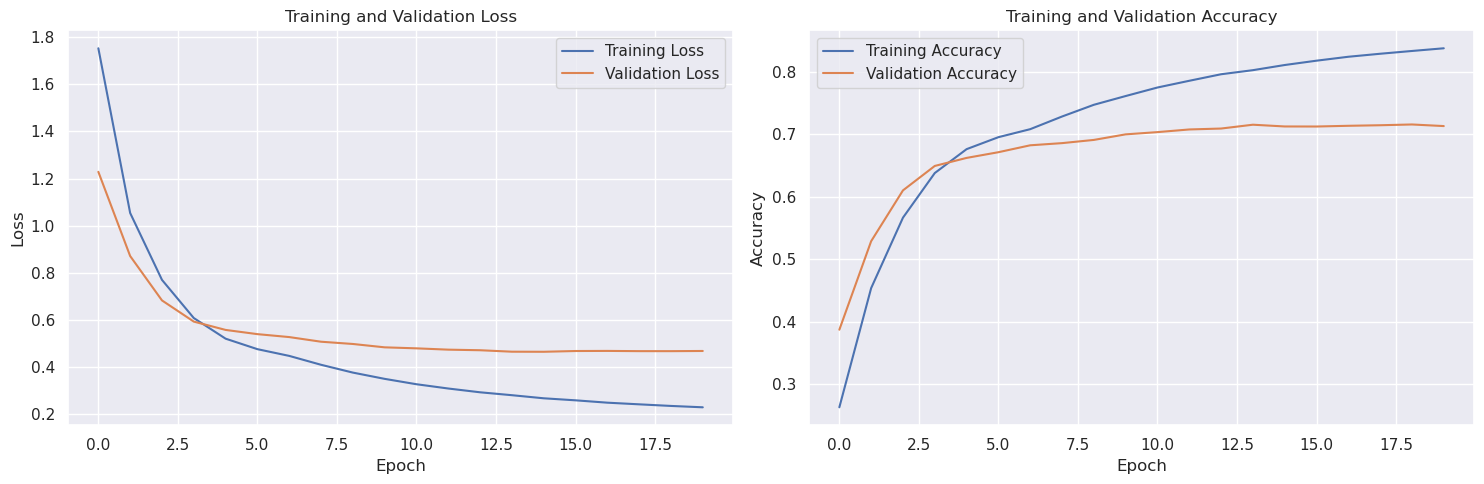

In [11]:
# Create dataloaders
print("Preparing datasets...")
train_dataloader, val_dataloader = prepare_dataset_from_keras(en_x, fr_y[:, :-1], batch_size=64)

MODEL_DIMENSION = 512
FEEDFORWARD_DIMENSION = 512
NUM_LAYERS = 6
NUM_HEADS = 8

# Create model
print("Creating Transformer model...")
model = Transformer(
    src_vocab_size=en_vocab_size,
    tgt_vocab_size=fr_vocab_size,
    model_dimension=MODEL_DIMENSION,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_LAYERS,
    num_decoder_layers=NUM_LAYERS,
    d_ff=FEEDFORWARD_DIMENSION,
    dropout=0.1,
).to(device)

print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

# Create learning rate scheduler with warmup using the custom learning rate optimizer
warmup_steps = 4000

class CustomLRAdamOptimizer:
    """
    Linear ramp learning rate for the warm-up number of steps and then start decaying
    according to the inverse square root law of the current training step number.

    Check out playground.py for visualization of the learning rate (visualize_custom_lr_adam).
    """
    def __init__(self, optimizer, model_dimension, num_of_warmup_steps):
        self.optimizer = optimizer
        self.model_size = model_dimension
        self.num_of_warmup_steps = num_of_warmup_steps
        self.current_step_number = 0

    def step(self):
        self.current_step_number += 1
        current_learning_rate = self.get_current_learning_rate()
        for p in self.optimizer.param_groups:
            p['lr'] = current_learning_rate
        self.optimizer.step()  # Apply gradients

    def get_current_learning_rate(self):
        step = self.current_step_number
        warmup = self.num_of_warmup_steps
        return self.model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))

    def zero_grad(self):
        self.optimizer.zero_grad()

custom_lr_optimizer = CustomLRAdamOptimizer(
    torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9),
    model_dimension=MODEL_DIMENSION,
    num_of_warmup_steps=warmup_steps
)

# Create loss function with label smoothing
criterion = LabelSmoothing(fr_vocab_size, PAD_IDX, smoothing=0.1).to(device)

# Train model using the custom learning rate optimizer
print("Training model...")
num_epochs = 20
history = train_model(
    train_dataloader,
    val_dataloader,
    model,
    criterion,
    custom_lr_optimizer,  # Using custom learning rate optimizer here
    None,                # No additional scheduler
    num_epochs=num_epochs,
    device=device,
)

# Plot training history
plot_history(history)

In [12]:
def translate(model, sentence, en_tokenizer, fr_tokenizer, device, max_len=20):
    """
    Translate an English sentence to French.
    """
    model.eval()
    
    # Clean the sentence and convert to sequence
    cleaned_sentence = clean_text(sentence)
    indexed = en_tokenizer.texts_to_sequences([cleaned_sentence])[0]
    
    # Pad sequence using max_len (this uses sequence_len for the source)
    src = pad_sequences([indexed], maxlen=max_len, padding='post')
    src = torch.tensor(src, dtype=torch.long).to(device)
    
    # Create a source mask that masks padded tokens (no need for create_masks here)
    src_mask = (src != PAD_IDX).unsqueeze(1)
    
    # Generate translation using greedy decoding
    with torch.no_grad():
        output = model.greedy_decode(
            src=src, 
            src_mask=src_mask,
            max_len=max_len, 
            start_symbol=START_IDX
        )
    
    # Since greedy_decode returns a list of lists, use the first sequence directly.
    output_seq = output[0]
    
    print("Decoded sequence:", output_seq)
    
    # Convert sequence of indices to text tokens (skip the start token)
    tokens = []
    for i in output_seq[1:]:
        if i == END_IDX:  # Stop if EOS token encountered.
            break
        tokens.append(fr_tokenizer.index_word.get(i, '<unk>'))
    
    return ' '.join(tokens)

# Test some translations
print("\nTesting translations:")
test_sentences = [
    "hello world",
    "how are you",
    "thank you very much",
    "good morning",
    "what is your name"
]

for sentence in test_sentences:
    print(f"English: {sentence}")
    translation = translate(model, sentence, en_tokenizer, fr_tokenizer, device)
    print(f"French:  {translation}")
    print()


Testing translations:
English: hello world
Iteration 0: next_word = [1036]
Iteration 1: next_word = [2]
Decoded sequence: [1, 1036, 2]
French:  salut

English: how are you
Iteration 0: next_word = [60]
Iteration 1: next_word = [823]
Iteration 2: next_word = [2]
Decoded sequence: [1, 60, 823, 2]
French:  comment vastu

English: thank you very much
Iteration 0: next_word = [250]
Iteration 1: next_word = [2]
Decoded sequence: [1, 250, 2]
French:  merci

English: good morning
Iteration 0: next_word = [991]
Iteration 1: next_word = [991]
Iteration 2: next_word = [2]
Decoded sequence: [1, 991, 991, 2]
French:  bonjour bonjour

English: what is your name
Iteration 0: next_word = [60]
Iteration 1: next_word = [19]
Iteration 2: next_word = [2575]
Iteration 3: next_word = [2575]
Iteration 4: next_word = [10]
Iteration 5: next_word = [2]
Decoded sequence: [1, 60, 19, 2575, 2575, 10, 2]
French:  comment tu tappelles tappelles est



## Question 2: BERT for sentiment analysis

For the last problem, we are going to learn how to use the huggingface library to train a simple BERT classifier for sentiment analysis.

We will use the IMDB dataset. You can find the dataset from huggingface using the following command:

```
from datasets import load_dataset
imdb = load_dataset("imdb")
```
To access BERT, use
```
from transformers import BertForSequenceClassification
#load pre-trained BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)
```
To reduce training complexity, you can choose to freeze the weight of the pretrained BERT model and only train the classifier. The classifier should have a minimum of 3 layers.
You might find https://huggingface.co/blog/sentiment-analysis-python and https://github.com/baotramduong/Twitter-Sentiment-Analysis-with-Deep-Learning-using-BERT/blob/main/Notebook.ipynb helpful.



In [14]:
from datasets import load_dataset

imdb = load_dataset("imdb")

In [15]:
from transformers import BertForSequenceClassification
import torch.nn as nn

# label dictionary from imdb dataset
label_dict = imdb['train'].features['label'].names

print(label_dict)

#load pre-trained BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)


# Freeze the pre-trained BERT parameters
for param in model.bert.parameters():
    param.requires_grad = False

# classifier with at least 4 layers for sentiment analysis
hidden_size = model.config.hidden_size
num_labels = len(label_dict)

classifier = nn.Sequential(
    nn.Linear(hidden_size, 512),   # Layer 1
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, 256),           # Layer 2
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 128),           # Layer 3
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, num_labels)     # Layer 4 (out)
)

# Replace the original classifier head with our custom classifier head
model.classifier = classifier

['neg', 'pos']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# training preparation
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer
import numpy as np
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 2e-5
WARMUP_PROPORTION = 0.1

# Tokenize the dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors='pt'
    )

print("Preparing datasets...")

# Tokenize train dataset
train_encodings = tokenize_data(imdb['train'])
train_labels = torch.tensor(imdb['train']['label'])

# Tokenize validation dataset
val_encodings = tokenize_data(imdb['test'])  #! NOTE: Using test set as validation
val_labels = torch.tensor(imdb['test']['label'])

# Create DataLoaders
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_encodings['token_type_ids'],
    train_labels
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_encodings['token_type_ids'],
    val_labels
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

model = model.to(device)

print("Creating Transformer model...")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {trainable_params:,} trainable parameters")

Using device: cuda
Preparing datasets...
Creating Transformer model...
Model has 558,210 trainable parameters


In [17]:
# Prepare optimizer and scheduler
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    correct_bias=False
)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_PROPORTION * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)



/hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.12/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
from tqdm import tqdm
import time

# Training function
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))
    
    for batch_idx, (input_ids, attention_mask, token_type_ids, labels) in progress_bar:
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        labels = labels.to(device)
        
        # Predict
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass with gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Update metrics
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.shape[0]
        
        # Just a progress bar update
        if (batch_idx + 1) % 50 == 0:
            progress_bar.set_description(
                f"Epoch {epoch+1}/{EPOCHS}, Batch {batch_idx+1}/{len(data_loader)}, Loss: {loss.item():.4f}"
            )
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, labels in data_loader:
            
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)
            
            # Predict
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            # Update running metrics
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.shape[0]
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

# Training loop
print("Training model...")
best_val_accuracy = 0

for epoch in range(EPOCHS):
    start_time = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(
        model,
        train_loader,
        optimizer,
        scheduler,
        device
    )
    
    # Eval
    val_loss, val_acc = evaluate(
        model,
        val_loader,
        device
    )
    
    # metrics
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{EPOCHS} - {elapsed_time:.2f}s - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
    
    # Save best
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_sentiment_model.pt')
        print(f"Best model saved with validation accuracy: {val_acc:.4f}")

# Load best model for final evaluation
model.load_state_dict(torch.load('best_sentiment_model.pt'))
final_val_loss, final_val_acc = evaluate(model, val_loader, device)
print(f"Final model performance - Validation Loss: {final_val_loss:.4f} - Validation Accuracy: {final_val_acc:.4f}")

Training model...


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/15, Batch 750/782, Loss: 0.6702: 100%|██████████| 782/782 [00:58<00:00, 13.31it/s]


Epoch 1/15 - 116.74s - Train Loss: 0.6879 - Train Acc: 0.5533 - Val Loss: 0.6719 - Val Acc: 0.6101
Best model saved with validation accuracy: 0.6101


Epoch 2/15, Batch 750/782, Loss: 0.5872: 100%|██████████| 782/782 [01:00<00:00, 13.01it/s]


Epoch 2/15 - 118.72s - Train Loss: 0.6401 - Train Acc: 0.6440 - Val Loss: 0.5903 - Val Acc: 0.6913
Best model saved with validation accuracy: 0.6913


Epoch 3/15, Batch 750/782, Loss: 0.6160: 100%|██████████| 782/782 [01:00<00:00, 13.03it/s]


Epoch 3/15 - 118.59s - Train Loss: 0.5849 - Train Acc: 0.6941 - Val Loss: 0.5368 - Val Acc: 0.7354
Best model saved with validation accuracy: 0.7354


Epoch 4/15, Batch 750/782, Loss: 0.5865: 100%|██████████| 782/782 [01:00<00:00, 12.86it/s]


Epoch 4/15 - 118.95s - Train Loss: 0.5674 - Train Acc: 0.7058 - Val Loss: 0.5307 - Val Acc: 0.7346


Epoch 5/15, Batch 750/782, Loss: 0.6133: 100%|██████████| 782/782 [01:00<00:00, 12.86it/s]


Epoch 5/15 - 118.79s - Train Loss: 0.5544 - Train Acc: 0.7184 - Val Loss: 0.5116 - Val Acc: 0.7506
Best model saved with validation accuracy: 0.7506


Epoch 6/15, Batch 750/782, Loss: 0.5237: 100%|██████████| 782/782 [01:00<00:00, 12.90it/s]


Epoch 6/15 - 118.85s - Train Loss: 0.5484 - Train Acc: 0.7234 - Val Loss: 0.5023 - Val Acc: 0.7553
Best model saved with validation accuracy: 0.7553


Epoch 7/15, Batch 750/782, Loss: 0.6610: 100%|██████████| 782/782 [01:00<00:00, 12.85it/s]


Epoch 7/15 - 118.89s - Train Loss: 0.5447 - Train Acc: 0.7262 - Val Loss: 0.5082 - Val Acc: 0.7520


Epoch 8/15, Batch 750/782, Loss: 0.5748: 100%|██████████| 782/782 [01:00<00:00, 12.86it/s]


Epoch 8/15 - 118.69s - Train Loss: 0.5436 - Train Acc: 0.7299 - Val Loss: 0.4967 - Val Acc: 0.7604
Best model saved with validation accuracy: 0.7604


Epoch 9/15, Batch 750/782, Loss: 0.5669: 100%|██████████| 782/782 [01:00<00:00, 12.94it/s]


Epoch 9/15 - 118.48s - Train Loss: 0.5410 - Train Acc: 0.7301 - Val Loss: 0.4919 - Val Acc: 0.7636
Best model saved with validation accuracy: 0.7636


Epoch 10/15, Batch 750/782, Loss: 0.7101: 100%|██████████| 782/782 [01:00<00:00, 12.83it/s]


Epoch 10/15 - 119.13s - Train Loss: 0.5400 - Train Acc: 0.7294 - Val Loss: 0.4890 - Val Acc: 0.7658
Best model saved with validation accuracy: 0.7658


Epoch 11/15, Batch 750/782, Loss: 0.4612: 100%|██████████| 782/782 [01:00<00:00, 13.00it/s]


Epoch 11/15 - 118.95s - Train Loss: 0.5366 - Train Acc: 0.7315 - Val Loss: 0.4873 - Val Acc: 0.7653


Epoch 12/15, Batch 750/782, Loss: 0.6073: 100%|██████████| 782/782 [01:00<00:00, 12.98it/s]


Epoch 12/15 - 118.78s - Train Loss: 0.5340 - Train Acc: 0.7343 - Val Loss: 0.4863 - Val Acc: 0.7667
Best model saved with validation accuracy: 0.7667


Epoch 13/15, Batch 750/782, Loss: 0.5044: 100%|██████████| 782/782 [01:00<00:00, 13.01it/s]


Epoch 13/15 - 118.58s - Train Loss: 0.5319 - Train Acc: 0.7350 - Val Loss: 0.4858 - Val Acc: 0.7672
Best model saved with validation accuracy: 0.7672


Epoch 14/15, Batch 750/782, Loss: 0.4942: 100%|██████████| 782/782 [01:00<00:00, 12.98it/s]


Epoch 14/15 - 118.58s - Train Loss: 0.5333 - Train Acc: 0.7328 - Val Loss: 0.4856 - Val Acc: 0.7668


Epoch 15/15, Batch 750/782, Loss: 0.4585: 100%|██████████| 782/782 [01:00<00:00, 13.01it/s]


Epoch 15/15 - 118.57s - Train Loss: 0.5319 - Train Acc: 0.7325 - Val Loss: 0.4850 - Val Acc: 0.7670
Final model performance - Validation Loss: 0.4858 - Validation Accuracy: 0.7672


In [19]:
# Generate predictions on test set for analysis
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, labels in data_loader:
            # Move data to device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

# Get predictions
test_predictions, test_true_labels = get_predictions(model, val_loader, device)

In [20]:
# classification report
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(test_true_labels, test_predictions, target_names=label_dict))


Classification Report:
              precision    recall  f1-score   support

         neg       0.77      0.76      0.77     12500
         pos       0.77      0.77      0.77     12500

    accuracy                           0.77     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.77      0.77      0.77     25000



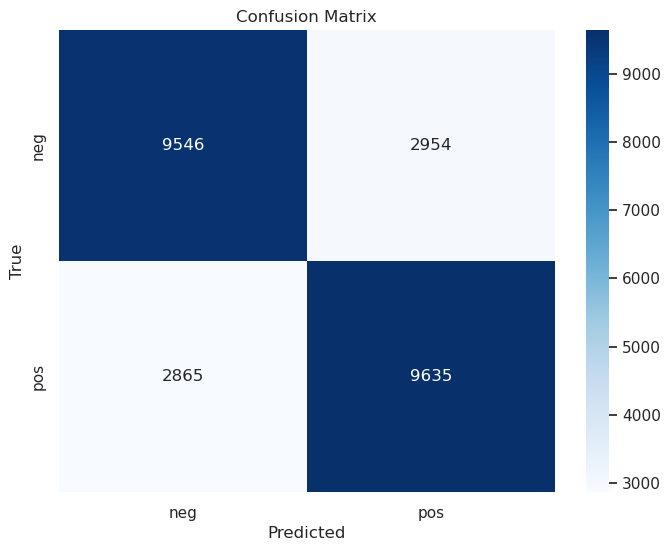

In [21]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict, yticklabels=label_dict)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()